### LSTM Drum Pattern generator

This notebook contains the implementation of Long Short-Term Memory (LSTM) model for generating drum patterns. It then uses some rule based filtering techniques to improve outputs.

## Project Set Up

In [ ]:
!pip install pytorch-ignite torchvision

In [ ]:
import torch
from torch import nn
import torchaudio
import torchaudio.functional as taF
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import glob
import os
import torchaudio.transforms as transforms
import numpy as np
import librosa
from torchvision.utils import save_image, make_grid
from torchvision.transforms import Compose, ToTensor
from ignite.engine import Engine, Events
from ignite.metrics import MeanSquaredError, Loss, RunningAverage
from IPython.display import Audio, display
from sklearn.preprocessing import MinMaxScaler
import soundfile as sf
import time

In [ ]:
# Set manual seed to ensure reproducability
SEED = 1221
torch.manual_seed(SEED)

# Get GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Train Midi Model

In [ ]:
!pip install mido

In [ ]:
import mido
import random
import math
import csv
import ast
from ipywidgets import IntProgress
from IPython.display import display
from google.colab import files
import soundfile as sf

In [ ]:
# Unzip Drum files
import zipfile

with zipfile.ZipFile("/content/DrumSounds.zip") as archive:
  archive.extractall("/content/DrumSound")

In [ ]:
# Load dataset to list
pattern_list = []
with open("dataset.tsv") as file:
    tsv_file = csv.reader(file, delimiter="\t")
    for line in tsv_file:
        pattern_list.append(ast.literal_eval("["+line[0]+"]"))
print(f"Original pattern list length: {len(pattern_list)}")

# Simplify kit from 14 to 6 pieces
# [ride, crash, oHH, closedHH, snare, kick]

relevant_columns = [-9, -8, -6, -3, -2, -1]

for i in range(len(pattern_list)):
  for j in range(len(pattern_list[i])):
    # Convert to 16b binary
    bit14_binary = bin(pattern_list[i][j]).split("b")[1].zfill(14)
    # Grab all regular colums for 6b encoding
    bit6_binary = "".join([bit14_binary[k] for k in relevant_columns])
    # Convert back to decimal
    dec = int(bit6_binary,2)
    # Replace item in list
    pattern_list[i][j] = dec

print(f"Post conversion pattern list length: {len(pattern_list)}")

# Clear empty lists post simplification

pattern_list = [pattern for pattern in pattern_list if sum(pattern) != 0]

print(f"Post empty list filtering pattern list length: {len(pattern_list)}")

# Get set of notes used

note_set=set() # Set only allows unique values
for pattern in pattern_list:
  for note in pattern:
            note_set.add(note)
note_set = list(note_set)
note_set.sort()

# Stores all posible notes in tensor
unique_values = torch.FloatTensor(note_set)

# Number of different characters
num_chars = len(note_set)

print(f"Note set length: {len(note_set)}")
print(f"Note set: {note_set}")

#convert to indexes in unique patterns
for i in range(len(pattern_list)):
  pattern_list[i] = [(unique_values == note).nonzero(as_tuple=True)[0] for note in pattern_list[i]]

# Convert lists to tensors
pattern_list = [torch.FloatTensor(pattern) for pattern in pattern_list]


Original pattern list length: 33472
Post conversion pattern list length: 33472
Post empty list filtering pattern list length: 33020
Note set length: 63
Note set: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]


In [ ]:
# Set Hyper Parameters
sentence_length = 17
pattern_length=32

In [ ]:
onehot_tensors = []

# Progress Bar
max_count = len(pattern_list)
print(max_count)
f = IntProgress(min=0, max=max_count) # instantiate the bar
display(f)

# Convert indexes to one hot
for pattern in pattern_list:
    onehot_tensor = torch.zeros((pattern_length, num_chars))
    for i in range(pattern_length):
      onehot_tensor[i,:] = (unique_values == pattern[i]).float().unsqueeze(0)
    onehot_tensors.append(onehot_tensor)
    f.value += 1

print(f"Shape of one hot tensors: {onehot_tensor.shape}")
print(f"Length of one hot tensor list: {len(onehot_tensors)}")

33020


IntProgress(value=0, max=33020)

Shape of one hot tensors: torch.Size([32, 63])
Length of one hot tensor list: 33020


In [ ]:
# Set up dataloaders

batch_size = 256
pattern_data = onehot_tensors

# Get training and test sizes
train_size = int(0.8 * len(pattern_data))
test_size = len(pattern_data) - train_size

print("Train size: " + str(train_size))
print("Test size: " + str(test_size))

# Set up dataloaders
pattern_train_dataset, pattern_test_dataset = torch.utils.data.random_split(pattern_data, [train_size, test_size])

pattern_train_loader = torch.utils.data.DataLoader(dataset=pattern_train_dataset, batch_size=batch_size, shuffle=True)
pattern_val_loader = torch.utils.data.DataLoader(dataset=pattern_test_dataset, batch_size=batch_size, shuffle=True)

del pattern_list

Train size: 26416
Test size: 6604


In [ ]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout=0.2):
        super(LSTM_Model, self).__init__()

        # Save Parameters
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define LSTM layers
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Define dropout layer
        self.dropout = nn.Dropout(dropout)

        # Define fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.ReLU()
            )


    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through LSTM layers
        out, _ = self.lstm1(x, (h0, c0))

        # Get the output of the last time step
        out = out[:, -1, :]
        # Pass through fully connected layers
        out = self.fc(out)

        return out

In [ ]:
# Define model parameters
# num_chars = Length of unique characters
# (manually assigned for ease)
num_chars = 63

input_size = num_chars
hidden_size = 512
output_size = num_chars
num_layers = 4
dropout = 0.3

# Initialize model
pattern_model = LSTM_Model(input_size, hidden_size, output_size, num_layers, dropout).to(device)

# Adam Optimiser
pattern_optimizer = torch.optim.Adam(pattern_model.parameters(), lr=1e-3, weight_decay=1e-4)

# Cross Entropy Loss
loss_funct = nn.CrossEntropyLoss()

In [ ]:
def evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    total_BCEloss = 0
    accuracy = 0

    # Disable gradient calculation during evaluation
    with torch.no_grad():
        for pattern in data_loader:
            # Data to device
            pattern = pattern.to(device)

            # Forward pass
            x_pred = model(pattern)
            max_pred = torch.argmax(x_pred, dim=1)

            # This is a very large dataset so I just grab a random sentence (17 step series) from the pattern
            j = random.randint(0, pattern_length - sentence_length)

            x_pred = model(pattern[:, j:j+sentence_length-1, :])

            # Get loss
            loss = loss_funct(x_pred, pattern[:, j+sentence_length-1, :])

            # Sum loss
            total_loss += loss

    # Calculate epoch loss metric

    epoch_loss = total_loss / len(data_loader)

    return epoch_loss

def train(model, train_loader, valid_loader, optimizer, num_epochs, saved_model, evaluate_every_n_epochs=1):


    train_losses = []
    valid_losses = []

    # Very high initial best lost
    best_valid_loss = 99999999999999999

    # For each epoch
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for pattern in train_loader:
            # Input to device
            pattern = pattern.to(device)

            # For each 17 step series in 32 step pattern
            for j in range(pattern_length-sentence_length):

              x_pred = model(pattern[:, j:j+sentence_length-1, :])

              # Calculate loss
              loss = loss_funct(x_pred, pattern[:, j+sentence_length-1, :])

              # Back Prop
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()

              # Tally epoch loss
              epoch_loss += (loss)/(pattern_length-sentence_length)


        # Epoch metrics
        epoch_loss /= len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch:{epoch+1}, Training Loss:{epoch_loss:.4f}')

        # Evaluate the network on the validation data
        if((epoch+1) % evaluate_every_n_epochs == 0):
            # Evaluate
            valid_loss = evaluate(model, valid_loader)

            print(f'Validation loss: {valid_loss:.6f}')
            print()
            valid_losses.append(valid_loss)
            # If best performance on validation set, save model
            if valid_loss<best_valid_loss:
              print("New best model, saving...\n")
              best_valid_loss = valid_loss
              torch.save(model.state_dict(), "best_pattern_model.pkl")

    return train_losses, valid_losses, model

class_threshold = 0.5
num_epochs = 100

# Train
train_losses, valid_losses, pattern_model = train(pattern_model, pattern_train_loader, pattern_val_loader, pattern_optimizer, num_epochs, 'best_model.pkl')

10


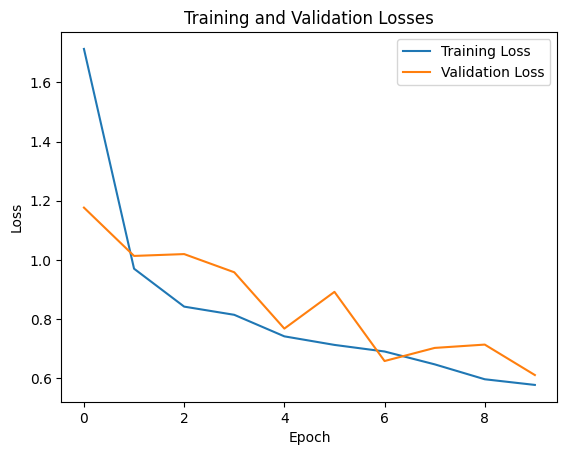

In [ ]:
train_losses = [loss.detach().cpu() for loss in train_losses]
valid_losses = [loss.detach().cpu() for loss in valid_losses]

# Plotting training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# *** Actual training continued for 40 epochs

## Load Midi Model

In [ ]:
# Load model

pattern_model = LSTM_Model(input_size, hidden_size, output_size, num_layers, dropout)
pattern_model.load_state_dict(torch.load('/content/best_pattern_model.pkl'))

pattern_model = pattern_model.to(device)

pattern_model.eval()

LSTM_Model(
  (lstm1): LSTM(63, 512, num_layers=4, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=63, bias=True)
    (3): ReLU()
  )
  (softmax): Softmax(dim=1)
)

## Beat Generation


In [ ]:
tempo = 120 # bpm
sr = 44100
# For midi file
step_size = int(sr*60/(tempo*4))
# For audio file
sample_length = int(pattern_length*sr*60/(tempo*4)) + 3*sr

# [ride, crash, oHH, closedHH, snare, kick]
drum_samples = [None,None,None,None,None,None,]

# Load drum samples
drum_samples[5], _ = librosa.load("/content/DrumSound/606bass.wav", sr=sr)
drum_samples[4], _ = librosa.load("/content/DrumSound/606snar.wav", sr=sr)
drum_samples[3], _ = librosa.load("/content/DrumSound/606chat.wav", sr=sr)
drum_samples[2], _ = librosa.load("/content/DrumSound/606ohat.wav", sr=sr)
drum_samples[1], _ = librosa.load("/content/DrumSound/808crash.wav", sr=sr)
drum_samples[0], _ = librosa.load("/content/DrumSound/808cowbell.wav", sr=sr)

In [ ]:
def new_seed_sentence():
  return pattern_data[random.randint(0, len(pattern_data))][:sentence_length-1,:].unsqueeze(0)

# Sample the distribution
def sample(a, temperature=1.0):

    # Apply temperature scaling
    a_log = torch.log(a) / temperature

    # Perform softmax operation
    a_exp = torch.exp(a_log)

    a_softmax = a_exp / torch.sum(a_exp)

    # Perform random sampling
    sampled_index = torch.multinomial(a_softmax, 1).item()

    # Create one-hot encoded vector
    one_hot = torch.zeros(1, a.shape[1])
    one_hot[0, sampled_index] = 1

    return one_hot

# Generate pattern
def generate_pattern(seed_sentence, temperature):

  # Get starting sentence
  sentence = seed_sentence

  pattern_model.eval()

  # Disable gradient calculation during evaluation
  with torch.no_grad():
          # Feed sentence into model, sample, repeat
          for i in range((pattern_length)):
            pattern = sentence[:,-sentence_length+1:,:].to(device)
            # Forward pass
            x_pred = pattern_model(pattern)
            # Sample
            choice = sample(x_pred, temperature).unsqueeze(0)
            # Add value to sentence
            sentence = torch.cat((sentence, choice), 1)
  # Get the last values from pattern
  sentence = sentence[:,sentence_length-1:,:].squeeze(0)

  # Equivelent to indexes in unique values
  sentence_ind = torch.argmax(sentence, dim=1)

  return sentence_ind



# Convert sentence to note indices
def convert_sentence(sentence_ind, midi_numbers):
  vals = []
  # Look up vals in unique values
  for ind in sentence_ind:
    vals.append(unique_values[ind].item())


  midi_note_list = []
  note_ind = []
  # Get 2 bit binary (kick and snare) for analytics
  bit2_binary = []
  # Convert back to binary and add note number to lists
  for i in range(len(vals)):
      bit6_binary = bin(int(vals[i])).split("b")[1].zfill(6)
      bit2_binary.append(bit6_binary[-2:])
      midi_note_list.append([])
      note_ind.append([])
      for j in range(6):
        if bit6_binary[j] == '1':
          midi_note_list[i].append(midi_numbers[j])
          note_ind[i].append(j)
  return midi_note_list, note_ind, bit2_binary

# Convert index to midi note number
def ind_to_midi_number(note_ind, midi_numbers):
  for i in range(len(note_ind)):
    for j in range(len(note_ind[i])):
      note_ind[i][j] = midi_numbers[note_ind[i][j]]
  return note_ind

# Create midi file
def notes_to_midi(notes, midi_output_path):
  # Create a new MIDI file
  mid = mido.MidiFile()
  track = mido.MidiTrack()
  mid.tracks.append(track)

  # Set default values for MIDI parameters
  ticks_per_beat = 120
  time = 0
  index=0

  rest = 0

  # Iterate over the notes and add them to the MIDI track
  for chord in notes:
      # If no notes in chord then it's a rest
      if len(chord)==0:
        rest+=1
      else:
        # Add each note in chord to file
        for note_number in chord:
            # Add note-on message
            track.append(mido.Message('note_on', note=note_number, velocity=64, time=time))
            time = 0  # Reset time for each chord
        rest = 0

      time = ticks_per_beat + (rest*ticks_per_beat)

  # Save the MIDI file
  mid.save(midi_output_path)

In [ ]:
# Generate new pattern from seed
def new_pattern_from_sentence(seed_sentence, temperature, midi_output_path, midi_numbers):

  sentence_ind = generate_pattern(seed_sentence, temperature)
  midi_note_list, note_ind, bit2_binary = convert_sentence(sentence_ind, midi_numbers)
  notes_to_midi(midi_note_list, midi_output_path)

  return midi_note_list, note_ind, bit2_binary

# Generate new pattern with new seed
def new_pattern_new_sentence(temperature, midi_output_path, midi_numbers):
  seed_sentence = new_seed_sentence()
  return new_pattern_from_sentence(seed_sentence, temperature, midi_output_path, midi_numbers)


In [ ]:
# Render to audio
def render_audio(audio_output_path, note_ind, sample_length):
  # Create empty clip
  clip = np.zeros(sample_length)
  i = 0
  # Loop through each step and add file
  for step in note_ind:
    for note in step:
        clip[i:i+len(drum_samples[note])] += drum_samples[note]
    i+=step_size
  # Normalise amplitude
  clip = librosa.util.normalize(clip)

  # Write out audio as 24bit PCM WAV
  sf.write(audio_output_path, clip, sr, subtype='PCM_24')

  # Display file
  display(Audio(clip, rate=sr))

In [ ]:
def analytics(bit2_binary, note_ind):

  half_pattern = int(pattern_length/2)
  matching_hits = 0
  snr_kick_hits = 0

  # Step weighting scores
  step_weightings_kick = [15,0,4,2,6,0,4,2]
  step_weightings_snare = [6,0,4,2,10,0,4,2]

  #Get list of all possible translated step weightings
  translated_step_weightings = [[],[]]

  for i in range(len(step_weightings_kick)):
      translated_step_weightings[1].append(step_weightings_kick[i:] + step_weightings_kick[:i])
      translated_step_weightings[0].append(step_weightings_snare[i:] + step_weightings_snare[:i])
  step_weightings_total = np.zeros(len(step_weightings_kick))

  # Check first half of pattern
  for i in range(half_pattern):
    hit = False
    # For each of the 2 binary bits
    for j in range(2):
      # If it's 1
      if bit2_binary[i][j] == "1":
        # Snare and kick tally
        snr_kick_hits+=1
        # Self similarity
        matching_hits+= int(bit2_binary[i][j]==bit2_binary[half_pattern+i][j])
        hit = True
        # Calculate all step scores
        for k in range(len(step_weightings_kick)):
          step_weightings_total[k] += translated_step_weightings[j][k][i%len(step_weightings_kick)]

  # Find best translation
  best_translation = np.argmax(step_weightings_total)

  # If theres snare hits, calculate metrics. Else 0
  if snr_kick_hits>0:
    self_similarity = matching_hits/snr_kick_hits
    step_weightings_avg = step_weightings_total[0]/snr_kick_hits
    best_step_weightings_avg= step_weightings_total[best_translation]/snr_kick_hits
  else:
    self_similarity = 0
    step_weightings_avg = 0
    best_step_weightings_avg = 0

  # Get the total number of notes
  total_num_notes = sum([len(ind) for ind in note_ind])

  # Get the best translation
  best_translation = (len(step_weightings_kick) - best_translation)%len(step_weightings_kick)

  return [total_num_notes, snr_kick_hits, self_similarity, step_weightings_avg, best_translation, best_step_weightings_avg]

# Visual representation of the pattern
def plot_pattern(pattern):
  # Populate grid
  grid = np.zeros((6,len(pattern)))
  for i in range(len(pattern)):
    for note in pattern[i]:
      grid[note, i] = 1
  # Plot
  plt.imshow(grid, cmap='Greys',  interpolation='nearest')
  plt.xlabel('Step')
  plt.yticks([])
  plt.ylabel('Kit piece')
  plt.show()

# Get pattern, generate analytics and comments
def get_pattern_and_analytics(temperature, midi_output_path, midi_numbers, min_total_hits, max_total_hits, min_snare_kick_hits, max_snare_kick_hits, min_self_similarity_score, min_step_weighting_score):
  # Get pattern + generate analytics
  _, note_ind, bit2_binary = new_pattern_new_sentence(temperature, midi_output_path, midi_numbers)
  pattern_analytics = analytics(bit2_binary, note_ind)

  # Get comments
  comments=""
  comment_found = False
  if pattern_analytics[0] <min_total_hits:
    comments+="- Too few overall notes.\n"
    comment_found = True
  elif pattern_analytics[0] > max_total_hits:
    comments+="- Too many overall notes."
    comment_found = True

  if pattern_analytics[1] < min_snare_kick_hits:
    comments+="- Too few snare/kick overall notes.\n"
    comment_found = True
  elif pattern_analytics[1] > max_snare_kick_hits:
    comments+="- Too many snare/kick overall notes.\n"
    comment_found = True

  if pattern_analytics[2] < min_self_similarity_score:
    comments+="- Self similarity score too low.\n"
    comment_found = True

  if pattern_analytics[3]<min_step_weighting_score:
    comments+="- Step weighting score too low.\n"
    comment_found = True
  return note_ind, bit2_binary, pattern_analytics, comment_found, comments

## UI

In [ ]:
#@title Sample Set Up
#@markdown Choose drum sample files:\
#@markdown _must be in '/content/DrumSound'_

tempo = 120 # bpm
sr = 44100
step_size = int(sr*60/(tempo*4))

sample_length = int(pattern_length*sr*60/(tempo*4)) + 3*sr

kick = "kick.wav"# @param {type:"string"}
snare = "snare.wav"# @param {type:"string"}
chh = "606chat.wav"# @param {type:"string"}
ohh = "606ohat.wav"# @param {type:"string"}
crash = "808crash.wav"# @param {type:"string"}
ride = "808cowbell.wav"# @param {type:"string"}

# load samples
# [ride, crash, oHH, closedHH, snare, kick]
drum_samples = [None,None,None,None,None,None,]

drum_samples[5], _ = librosa.load("/content/DrumSound/"+kick, sr=sr)
drum_samples[4], _ = librosa.load("/content/DrumSound/"+snare, sr=sr)
drum_samples[3], _ = librosa.load("/content/DrumSound/"+chh, sr=sr)
drum_samples[2], _ = librosa.load("/content/DrumSound/"+ohh, sr=sr)
drum_samples[1], _ = librosa.load("/content/DrumSound/"+crash, sr=sr)
drum_samples[0], _ = librosa.load("/content/DrumSound/"+ride, sr=sr)

Pattern:



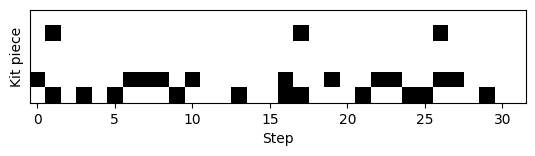


Pattern audio:




Analytics:
1 Total number of hits                    25
2 Number of snare and kick hits           10
3 Self similarity score                   0.8
4 Step weighting score                    2.4
5 Best translation                        5
6 Best translation step weighting score   5.4


Comments:
- Step weighting score too low.

- Better alternative start position found.
- Translation better by a large amount.

Translation:



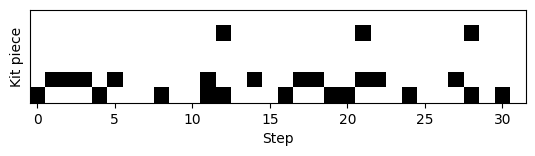

In [ ]:
audio_output_path = '/content/output.wav'
midi_output_path = '/content/output.mid'
translated_audio_output_path = '/content/translated_output.wav'
translated_midi_output_path = '/content/translated_output.mid'
#@title Pattern Generator

#@markdown Pattern Controls:
temperature = 0.25 #@param {type:'slider', min:0.1, max:2, step:0.05}
generate_translation = True # @param {type:"boolean"}
filter = False # @param {type:"boolean"}

#@markdown Filter Controls:
min_total_hits = 10 #@param {type:'slider', min:1, max:32, step:1}
max_total_hits = 41 #@param {type:'slider', min:10, max:48, step:1}

min_snare_kick_hits = 5 #@param {type:'slider', min:1, max:32, step:1}
max_snare_kick_hits = 18 #@param {type:'slider', min:11, max:32, step:1}

min_self_similarity_score = 0.6 #@param {type:'slider', min:0.05, max:1, step:0.05}

min_step_weighting_score = 3.5 #@param {type:'slider', min:0, max:20, step:0.5}



#@markdown Global Controls:
download_midi = False # @param {type:"boolean"}
download_audio = False # @param {type:"boolean"}

midi_numbers = [51, 49, 46, 42, 38, 36]

pattern_found = False
patterns_generated = 0

# if filter is on, keep generating until match found
while not pattern_found:
  note_ind, bit2_binary, pattern_analytics, comment_found, comments = get_pattern_and_analytics(temperature, midi_output_path, midi_numbers, min_total_hits, max_total_hits, min_snare_kick_hits, max_snare_kick_hits, min_self_similarity_score, min_step_weighting_score)
  patterns_generated +=1
  if not (comment_found and filter):
    pattern_found = True

#if comment_found and filter:

print("Pattern:\n")
plot_pattern(note_ind)
print("\nPattern audio:\n")
render_audio(audio_output_path, note_ind, sample_length)

# Print number of patterns searched to find match if filter is on
if filter:
  print(f"\nNumber of patterns generated to find match: {patterns_generated}")

print("\nAnalytics:")
print(f"1 Total number of hits                    {pattern_analytics[0]}")
print(f"2 Number of snare and kick hits           {pattern_analytics[1]}")
print(f"3 Self similarity score                   {pattern_analytics[2]}")
print(f"4 Step weighting score                    {pattern_analytics[3]}")
print(f"5 Best translation                        {pattern_analytics[4]}")
print(f"6 Best translation step weighting score   {pattern_analytics[5]}")
print()

if comment_found:
  print("\nComments:")
  print(comments)

if pattern_analytics[4]!=0:
  print("- Better alternative start position found.")
  if pattern_analytics[5]-pattern_analytics[3]>1:
    print("- Translation better by a large amount.")
  else:
    print("- Translation better by a small amount.")
  if pattern_analytics[5]<min_step_weighting_score:
    print("- New step weighting score still too low.")

  translation = note_ind[pattern_analytics[4]:]+note_ind[:pattern_analytics[4]]
  print("\nTranslation:\n")
  plot_pattern(translation)
  print()

  #render audio and midi
  render_audio(audio_output_path, translation, sample_length)
  midi_list = ind_to_midi_number(translation, midi_numbers)
  notes_to_midi(midi_list, translated_midi_output_path)

# Download files
if download_audio:
  files.download(audio_output_path)
if download_midi:
  files.download(midi_output_path)
